# Import Libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import ElasticNet, LassoCV, Lasso
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

In [ ]:
# import statsmodels.api as sma
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/')

# Import Dataset

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# check to see if the column order is the same for concatination
list(train_df.iloc[:, 0:80].columns) == list(test_df.columns)

True

In [ ]:
# concatinate both train and test for imputation later
# drop ID from the beginning
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df.drop(columns=['Id'], inplace=True)

# Data Understanding and Visualization

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.tail()

In [ ]:
full_df.describe().T

In [ ]:
full_df.describe(include='object').T

In [ ]:
# heat map with numerical variables
# checking correlation
corrmat = full_df.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='YlGnBu', annot=True,linewidths=.3, fmt='.1f', annot_kws={'size': 8})

In [ ]:
# checking VIF
# def vif_arr(df):
#   vif = pd.DataFrame()
#   df = sma.add_constant(df)
#   vif['variables'] = df.columns
#   vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

#   return vif

In [ ]:
# vif_arr(full_df.loc[:, full_df.columns!='SalePrice'].select_dtypes(exclude='object'))

In [ ]:
# check out target variable
sns.histplot(x='SalePrice', data=full_df)

In [ ]:
plt.subplots(figsize=(16, 9))
g = sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=full_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
None # do not show the get_xticklabels objects

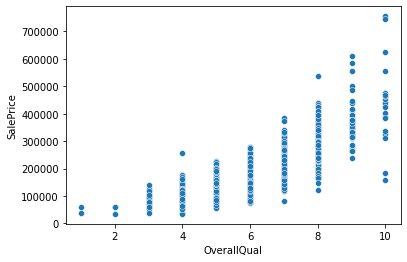

In [ ]:
sns.scatterplot(x='OverallQual',y='SalePrice', data=train_df)

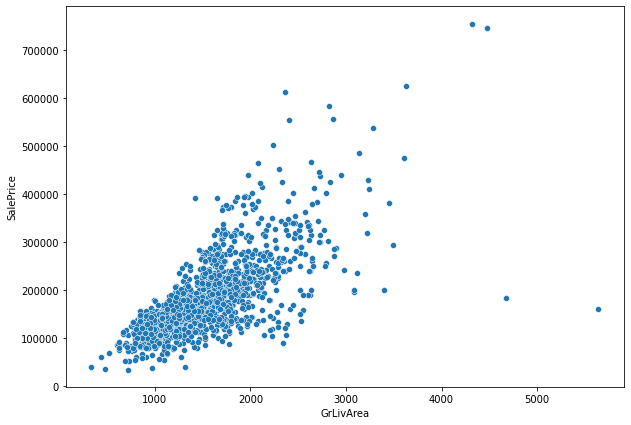

In [ ]:
plt.subplots(figsize=(10, 7))
sns.scatterplot(x='GrLivArea',y='SalePrice', data=train_df)

In [ ]:
full_df.drop(columns='SalePrice').isnull().mean().sort_values(ascending=False)

In [ ]:
# ext_cols = [string for string in list(full_df.columns) if 'Exter' in string]

# Data Preprocessing / Feature Engineering

#### Remove Outliers

In [ ]:
full_df = full_df[~((full_df['GrLivArea']>4500) & (full_df['SalePrice']<300000))]

#### Imputation (fill in the mssing values)

In [ ]:
# the special cases
full_df.loc[(full_df['MasVnrType'].isnull()) & (full_df['MasVnrArea'].notnull()), 'MasVnrType'] = 'BrkCmn'
full_df.loc[(full_df['BsmtExposure'].isnull()) & (full_df['BsmtQual'].notnull()), 'BsmtExposure'] = 'No'
full_df['KitchenQual'] = full_df['KitchenQual'].fillna('TA')

In [ ]:
# fill with 0
full_df['MasVnrArea'] = full_df['MasVnrArea'].fillna(0)
full_df['BsmtFinSF1'] = full_df['BsmtFinSF1'].fillna(0)
full_df['BsmtFinSF2'] = full_df['BsmtFinSF2'].fillna(0)
full_df['BsmtUnfSF'] = full_df['BsmtUnfSF'].fillna(0)
full_df['TotalBsmtSF'] = full_df['TotalBsmtSF'].fillna(0)
full_df['BsmtFullBath'] = full_df['BsmtFullBath'].fillna(0)
full_df['BsmtHalfBath'] = full_df['BsmtHalfBath'].fillna(0)
full_df['GarageCars'] = full_df['GarageCars'].fillna(0)
full_df['GarageArea'] = full_df['GarageArea'].fillna(0)
full_df['GarageYrBlt'] = full_df['GarageYrBlt'].fillna(0)

In [ ]:
# fill with median
full_df['LotFrontage'] = full_df['LotFrontage'].fillna(full_df['LotFrontage'].median())

In [ ]:
# fill with None
full_df['MasVnrType'] = full_df['MasVnrType'].fillna('None')
full_df['BsmtQual'] = full_df['BsmtQual'].fillna('None')
full_df['BsmtCond'] = full_df['BsmtCond'].fillna('None')
full_df['BsmtFinType1'] = full_df['BsmtFinType1'].fillna('None')
full_df['BsmtFinType2'] = full_df['BsmtFinType2'].fillna('None')
full_df['FireplaceQu'] = full_df['FireplaceQu'].fillna('None')
full_df['GarageType'] = full_df['GarageType'].fillna('None')
full_df['GarageFinish'] = full_df['GarageFinish'].fillna('None')
full_df['GarageQual'] = full_df['GarageQual'].fillna('None')
full_df['GarageCond'] = full_df['GarageCond'].fillna('None')
full_df['BsmtExposure'] = full_df['BsmtExposure'].fillna('None')
full_df["PoolQC"] = full_df["PoolQC"].fillna("None")
full_df["MiscFeature"] = full_df["MiscFeature"].fillna("None")
full_df["Alley"] = full_df["Alley"].fillna("None")
full_df["Fence"] = full_df["Fence"].fillna("None")

In [ ]:
# fill with mode
full_df['MSZoning'] = full_df['MSZoning'].fillna(full_df['MSZoning'].mode()[0])
full_df['Utilities'] = full_df['Utilities'].fillna(full_df['Utilities'].mode()[0])
full_df['Exterior1st'] = full_df['Exterior1st'].fillna(full_df['Exterior1st'].mode()[0])
full_df['Exterior2nd'] = full_df['Exterior2nd'].fillna(full_df['Exterior2nd'].mode()[0])
full_df['SaleType'] = full_df['SaleType'].fillna(full_df['SaleType'].mode()[0])
full_df['Functional'] = full_df['Functional'].fillna(full_df['Functional'].mode()[0])
full_df['Electrical'] = full_df['Electrical'].fillna(full_df['Functional'].mode()[0])

### Convert to ordinal variable (in interger form)

In [ ]:
# ExterQual, ExterCond, HeatingQC
ext_ord = OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
ext_ord.fit([['None'], ['Po'], ['Fa'], ['TA'], ['Gd'], ['Ex']])
full_df['ExterQual'] = ext_ord.transform(full_df[['ExterQual']])
full_df['ExterCond'] = ext_ord.transform(full_df[['ExterCond']])
full_df['HeatingQC'] = ext_ord.transform(full_df[['HeatingQC']])
full_df['PoolQC'] = ext_ord.transform(full_df[['PoolQC']])

In [ ]:
# BsmtQual, BsmtCond, FireplaceQu, GarageQual, GarageCond
bsmt_ord = OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
bsmt_ord.fit([['None'], ['Po'], ['Fa'], ['TA'], ['Gd'], ['Ex']])
full_df['BsmtQual'] = bsmt_ord.transform(full_df[['BsmtQual']])
full_df['BsmtCond'] = bsmt_ord.transform(full_df[['BsmtCond']])
full_df['FireplaceQu'] = bsmt_ord.transform(full_df[['FireplaceQu']])
full_df['GarageQual'] = bsmt_ord.transform(full_df[['GarageQual']])
full_df['GarageCond'] = bsmt_ord.transform(full_df[['GarageCond']])

### Convert numeric data into categorical data

In [ ]:
# year built
# full_df['YearBuilt'] = full_df['YearBuilt'].map(lambda x: 'Newest' if x>=1980 else ('New' if x>=1950 else ('Old' if x>=1920 else 'Oldest')))

# # year remodeling
# full_df['YearRemodAdd'] = full_df['YearRemodAdd'].map(lambda x: 'Newest' if x>=1990 else ('New' if x>=1970 else 'Old'))

full_df['MSSubClass'] = full_df['MSSubClass'].astype(str)
# convert these two into categorical variables coz they dont seem to contribute to SalePrice
full_df['YrSold'] = full_df['YrSold'].astype(str)
full_df['MoSold'] = full_df['MoSold'].astype(str)

### Create New Variable

In [ ]:
# total squarefeet
# full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF'] + full_df['LotArea'] + full_df['MasVnrArea'] + full_df['GrLivArea'] + full_df['GarageArea']
full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF']
full_df['TotalOutdoorSF'] = full_df['WoodDeckSF'] + full_df['OpenPorchSF'] + full_df['EnclosedPorch'] + full_df['ScreenPorch'] + full_df['3SsnPorch']

#### Box-cox transformation

In [ ]:
num_var = full_df.select_dtypes(exclude="object").columns

skewed_var = full_df[num_var].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame()
skewness['Skew_value'] = skewed_var
skewness.head(15)

,Skew_value
MiscVal,21.939672
PoolQC,19.548879
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [ ]:
# turn heavily skewed numeric variables towards normal
# excluding ordinal variables and counts
full_df['MiscVal'] = boxcox1p(full_df['MiscVal'], 0.15)
full_df['PoolArea'] = boxcox1p(full_df['PoolArea'], 0.15)
full_df['LotArea'] = boxcox1p(full_df['LotArea'], 0.15)
full_df['LowQualFinSF'] = boxcox1p(full_df['LowQualFinSF'], 0.15)
full_df['3SsnPorch'] = boxcox1p(full_df['3SsnPorch'], 0.15)
full_df['KitchenAbvGr'] = boxcox1p(full_df['KitchenAbvGr'], 0.15)
full_df['EnclosedPorch'] = boxcox1p(full_df['EnclosedPorch'], 0.15)
full_df['BsmtFinSF2'] = boxcox1p(full_df['BsmtFinSF2'], 0.15)
full_df['ScreenPorch'] = boxcox1p(full_df['ScreenPorch'], 0.15)

# log transformation
full_df['LotFrontage'] = boxcox1p(full_df['LotFrontage'], 0)
full_df['1stFlrSF'] = boxcox1p(full_df['1stFlrSF'], 0)
full_df['GrLivArea'] = boxcox1p(full_df['GrLivArea'], 0)
full_df['WoodDeckSF'] = boxcox1p(full_df['WoodDeckSF'], 0)
full_df['OpenPorchSF'] = boxcox1p(full_df['OpenPorchSF'], 0)
full_df['TotalSF'] = boxcox1p(full_df['TotalSF'], 0)
full_df['TotalOutdoorSF'] = boxcox1p(full_df['TotalOutdoorSF'], 0)

#### One-hot encoding (dummy variables)

In [ ]:
full_df = pd.get_dummies(data=full_df)

### log transform the TARGET variable for official scoring

In [ ]:
full_df['SalePrice'] = np.log1p(full_df['SalePrice'])

In [ ]:
full_df.shape

(2917, 298)

In [ ]:
# split full_df back into train set and test set
test_set = full_df.iloc[1458:, :].copy()
test_set.drop(columns=['SalePrice'], inplace=True)
train_set = full_df.iloc[:1458, :].copy()

# Building Model and Model Evaluation

In [ ]:
y_train = train_set['SalePrice']
X_train = train_set.drop(columns=['SalePrice'])

In [ ]:
# cross validation score function
fold = KFold(n_splits=12, random_state=42, shuffle=True)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = fold))
    return(rmse)

In [ ]:
# error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Model 1 - Lasso

In [ ]:
# use robust scaler to be robust to outliers
best_alpha = 0.00099
model_lasso = make_pipeline(RobustScaler(),Lasso(alpha=best_alpha, max_iter=30000))

In [ ]:
scores = {}

score = rmse_cv(model_lasso)
print("Lasso (mean, std): {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['model_lasso'] = (score.mean(), score.std())

Lasso (mean, std): 0.1096 (0.0168)


In [ ]:
lasso_model_fit = model_lasso.fit(X_train, y_train)
lasso_train_pred = lasso_model_fit.predict(X_train)
lasso_pred = np.floor(np.expm1(lasso_model_fit.predict(test_set)))
print(rmsle(y_train, lasso_train_pred))

0.10195059589336608


## Model 2 - XGBoost

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
params = {"eta":0.05}

In [ ]:
# hyperparameter tuning
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,6)
    for min_child_weight in range(0,4)
]

In [ ]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=100
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=2, min_child_weight=0
	MAE 0.009331599999999999 for 647 rounds
CV with max_depth=2, min_child_weight=1
	MAE 0.009331599999999999 for 647 rounds
CV with max_depth=2, min_child_weight=2
	MAE 0.0091798 for 689 rounds
CV with max_depth=2, min_child_weight=3
	MAE 0.009102599999999999 for 720 rounds
CV with max_depth=3, min_child_weight=0
	MAE 0.009199200000000001 for 618 rounds
CV with max_depth=3, min_child_weight=1
	MAE 0.009199200000000001 for 618 rounds
CV with max_depth=3, min_child_weight=2
	MAE 0.009106799999999998 for 556 rounds
CV with max_depth=3, min_child_weight=3
	MAE 0.009180400000000002 for 820 rounds
CV with max_depth=4, min_child_weight=0
	MAE 0.0092168 for 475 rounds
CV with max_depth=4, min_child_weight=1
	MAE 0.0092168 for 475 rounds
CV with max_depth=4, min_child_weight=2
	MAE 0.0091706 for 433 rounds
CV with max_depth=4, min_child_weight=3
	MAE 0.0092138 for 501 rounds
CV with max_depth=5, min_child_weight=0
	MAE 0.0094006 for 728 rounds
CV with max_d

In [ ]:
params = {"eta":0.05, 'max_depth': 2, 'min_child_weight': 3}
params

{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 3}

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=720, max_depth=2, learning_rate=0.05, min_child_weight=3,objective='reg:squarederror') #the params were tuned using xgb.cv
# model_xgb.fit(X_train, y_train)

In [ ]:
score = rmse_cv(model_xgb)
print("XGBoost (mean, std): {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['model_xgb'] = (score.mean(), score.std())

XGBoost (mean, std): 0.1147 (0.0158)


In [ ]:
xgb_model_fit = model_xgb.fit(X_train, y_train)
xgb_train_pred = xgb_model_fit.predict(X_train)
xgb_pred = np.floor(np.expm1(xgb_model_fit.predict(test_set)))
print(rmsle(y_train, xgb_train_pred))

0.07599636784227382


## Model 3 - SVR

In [ ]:
# defining parameter range
param_grid = {'C': [1, 3, 5, 10, 20, 50], 
              'gamma': [x/10000000 for x in (1,10,15,20,100,200,3000)],
              'epsilon': [0.005, 0.008, 0.01]} 
  
svm_cv = GridSearchCV(SVR(kernel='rbf'), param_grid, refit = True, verbose = 2)
  
# fitting the model for grid search
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] C=1, epsilon=0.005, gamma=1e-07 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=1, epsilon=0.005, gamma=1e-07, total=   0.7s
[CV] C=1, epsilon=0.005, gamma=1e-07 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .................. C=1, epsilon=0.005, gamma=1e-07, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-07 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-07, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-07 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-07, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-07 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-07, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-06 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-06, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-06 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-06, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-06 .................................
[CV] .................. C=1, epsilon=0.005, gamma=1e-06, total=   0.8s
[CV] C=1, epsilon=0.005, gamma=1e-06 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed: 11.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 3, 5, 10, 20, 50],
                         'epsilon': [0.005, 0.008, 0.01],
                         'gamma': [1e-07, 1e-06, 1.5e-06, 2e-06, 1e-05, 2e-05,
                                   0.0003]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
# best parameter
print(svm_cv.best_params_)
  
# best model
print(svm_cv.best_estimator_)

# best score
print(svm_cv.best_score_)

{'C': 50, 'epsilon': 0.005, 'gamma': 1e-07}
SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma=1e-07,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.8192333534075141


In [ ]:
model_svr = make_pipeline(RobustScaler(), SVR(C= 50, epsilon= 0.005, gamma=1e-07))

In [ ]:
score = rmse_cv(model_svr)
print("SVR (mean, std): {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['model_svr'] = (score.mean(), score.std())

SVR (mean, std): 0.3247 (0.0195)


In [ ]:
svr_model_fit = model_svr.fit(X_train, y_train)
svr_train_pred = svr_model_fit.predict(X_train)
svr_pred = np.floor(np.expm1(svr_model_fit.predict(test_set)))
print(rmsle(y_train, svr_train_pred))

0.3201184655936208


## Model 4 - Random Forest

In [ ]:
param_grid = {'n_estimators': [800,1000,1200,1400],
               'max_depth': [10,15],
               'min_samples_split': [5],
               'min_samples_leaf': [5]}
  
rf_cv = GridSearchCV(RandomForestRegressor(max_features=None, bootstrap=True), param_grid, verbose = 1, n_jobs=-1)
  
# fitting the model for grid search
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
# best parameter
print(rf_cv.best_params_)
  
# best model
print(rf_cv.best_estimator_)

# best score
print(rf_cv.best_score_)

{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 800}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
0.8768570248598009


In [ ]:
model_rf = RandomForestRegressor(n_estimators=800,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [ ]:
score = rmse_cv(model_rf)
print("RandomForest (mean, std): {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['model_rf'] = (score.mean(), score.std())

RandomForest (mean, std): 0.1371 (0.0162)


In [ ]:
rf_model_fit = model_rf.fit(X_train, y_train)
rf_train_pred = rf_model_fit.predict(X_train)
rf_pred = np.floor(np.expm1(rf_model_fit.predict(test_set)))
print(rmsle(y_train, rf_train_pred))

0.08751276962360396


## Model 5 - GBR

In [ ]:
param_grid = {'n_estimators': [3000,6000,8000],
               'max_depth': [4,5,6],
               'min_samples_split': [10],
               'min_samples_leaf': [15]}
  
gbr_cv = GridSearchCV(GradientBoostingRegressor(max_features='sqrt', loss='huber', learning_rate=0.01), param_grid, verbose = 1, n_jobs=-1)
  
# fitting the model for grid search
gbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.01,
                                                 loss='huber', max_depth=3,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
        

In [ ]:
# best parameter
print(gbr_cv.best_params_)
  
# best model
print(gbr_cv.best_estimator_)

# best score
print(gbr_cv.best_score_)

{'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 6000}
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=6000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
0.9197130561849566


In [ ]:
# Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

In [ ]:
score = rmse_cv(model_gbr)
print("Gradient Boosting Regressor (mean, std): {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['model_gbr'] = (score.mean(), score.std())

Gradient Boosting Regressor (mean, std): 0.1120 (0.0164)


In [ ]:
gbr_model_fit = model_gbr.fit(X_train, y_train)
gbr_train_pred = gbr_model_fit.predict(X_train)
gbr_pred = np.floor(np.expm1(gbr_model_fit.predict(test_set)))
print(rmsle(y_train, gbr_train_pred))

0.06452349866048848


## Ensemble Models (Stacking)
##### Stack good performance models

In [ ]:
pd.DataFrame(scores).T.sort_values(by=0)

,0,1
model_lasso,0.109560,0.016828
model_gbr,0.112023,0.016377
model_xgb,0.114732,0.015837
model_rf,0.137080,0.016231
model_svr,0.324680,0.019460


In [ ]:
regressors = (model_lasso,model_gbr,model_rf)

stacking_reg = StackingCVRegressor(regressors=regressors,
                                meta_regressor= model_lasso,
                                use_features_in_secondary=True)

# somehow including XGB incurs error while using stacking_reg
# need to find out the workaround if want to stack xgb in the future                            

In [ ]:
stacked_reg_model_fit = stacking_reg.fit(np.array(X_train), np.array(y_train))
stacked_train_pred = stacked_reg_model_fit.predict(X_train)
stacked_pred = np.floor(np.expm1(stacked_reg_model_fit.predict(test_set)))
print(rmsle(y_train, stacked_train_pred))

0.07911498128898327


# Submission

In [ ]:
ensemble = ((stacked_pred * 0.33) + (lasso_pred * 0.24) + (gbr_pred * 0.21) + (xgb_pred * 0.07) + (rf_pred * 0.14)  + (svr_pred * 0.01))
# ensemble = ((stacked_pred * 0.30) + (lasso_pred * 0.24) + (gbr_pred * 0.21) + (xgb_pred * 0.10) + (rf_pred * 0.14)  + (svr_pred * 0.01))

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['SalePrice'] = ensemble
submission.head()

,Id,SalePrice
0,1461,123536.710469
1,1462,155923.429805
2,1463,186269.810430
3,1464,194740.220508
4,1465,189661.510391


In [ ]:
submission.to_csv('sub_ensemble6.csv', index=False)